In [1]:
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt


In [2]:
class Image_Stitching():
    def __init__(self) :
        self.ratio=0.85
        self.min_match=10
        self.sift=cv2.SIFT_create()
        self.smoothing_window_size=100

    def registration(self,img1,img2):
        kp1, des1 = self.sift.detectAndCompute(img1, None)
        kp2, des2 = self.sift.detectAndCompute(img2, None)
        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)
        good_points = []
        good_matches=[]
        for m1, m2 in raw_matches:
            if m1.distance < self.ratio * m2.distance:
                good_points.append((m1.trainIdx, m1.queryIdx))
                good_matches.append([m1])
        img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=2)
        cv2.imwrite('matching.jpg', img3)
        plt.imshow(img3)
        plt.show()
        if len(good_points) > self.min_match:
            image1_kp = np.float32(
                [kp1[i].pt for (_, i) in good_points])
            image2_kp = np.float32(
                [kp2[i].pt for (i, _) in good_points])
            H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        return H

    def create_mask(self,img1,img2,version):
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2
        offset = int(self.smoothing_window_size / 2)
        barrier = img1.shape[1] - int(self.smoothing_window_size / 2)
        mask = np.zeros((height_panorama, width_panorama))
        if version== 'left_image':
            mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
            mask[:, :barrier - offset] = 1
        else:
            mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
            mask[:, barrier + offset:] = 1
        return cv2.merge([mask, mask, mask])

    def blending(self,img1,img2):
        H = self.registration(img1,img2)
        height_img1 = img1.shape[0]
        width_img1 = img1.shape[1]
        width_img2 = img2.shape[1]
        height_panorama = height_img1
        width_panorama = width_img1 +width_img2

        panorama1 = np.zeros((height_panorama, width_panorama, 3))
        mask1 = self.create_mask(img1,img2,version='left_image')
        plt.imshow(mask1)
        plt.show()
        panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
        panorama1 *= mask1
        mask2 = self.create_mask(img1,img2,version='right_image')
        panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama))*mask2
        result=panorama1+panorama2

        # Normalize pixel values
        result = result / np.max(result)

        rows, cols = np.where(result[:, :, 0] != 0)
        min_row, max_row = min(rows), max(rows) + 1
        min_col, max_col = min(cols), max(cols) + 1
        final_result = result[min_row:max_row, min_col:max_col, :]
        return final_result

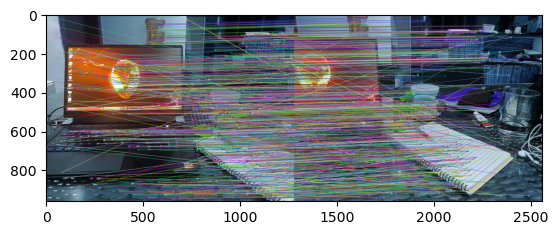

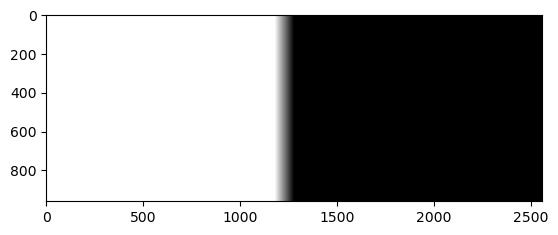

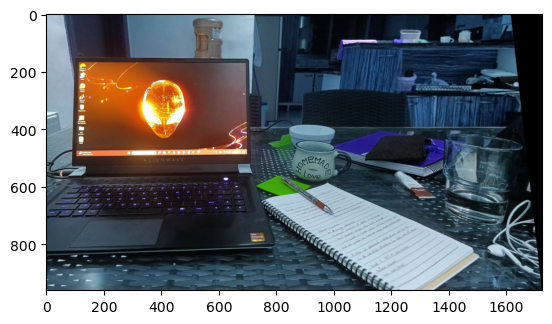

In [4]:
img1 = cv2.imread(r"C:\Users\islam\Desktop\LAST semester at GJU\Machine II\MLII Assignment 2\Assign2Q2\imgleft.jpg")
img2 = cv2.imread(r"C:\Users\islam\Desktop\LAST semester at GJU\Machine II\MLII Assignment 2\Assign2Q2\imgright.jpg")
final=Image_Stitching().blending(img1,img2)
cv2.imwrite('panorama.jpg', final)

plt.imshow(final)
plt.show()